# Time Series Forecasting of airline passengers
In this use-case, we will be using historical data of an airline containing no. of passengers for each month of the year.
We will be using this historical data to forecast the no. of passengers who will be booking that airline for a particular month.

### Box - Jenkins Methodology

We will use Box-Jenkins methodology for time-series analysis :
1. __Data conditioning & Model Selection__ : TS decomposition and Making TS stationary (Differencing & Dikey Fuller Test) 
2. __Estimation of model parameters__ : Compute coefficients of model 
3. __Model Validation__ : Analyzing residuals (normality, white noise, Ljung-Box test)

### Importing required libraries for time series analysis

###### Installing pyramid package to use auto_arima model

In [1]:
#!pip install pmdarima

In [2]:
#!pip install plotly

###### Installing below three packages to use Fb's prophet package

In [3]:
#!pip install pystan==2.19.1.1

In [4]:
#conda install libpython m2w64-toolchain -c msys2

In [5]:
#!pip install prophet

In [6]:
# Importing Basic libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing time series specific libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
import pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax
import prophet
from prophet import Prophet

# Miscellaneous libararies
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from random import random

# Libaraies for evaluation of model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMAResults


###### Importing Data

In [7]:
df = pd.read_csv('F:/DATA SCIENCE/TIME SERIES/international-airline-passengers.csv', names = ['year','passengers'], header = 0)

In [8]:
df

,year,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [9]:
# Removing last row as it is not valid
df = df.iloc[:(len(df) - 1),]

In [10]:
df

,year,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0


In [11]:
df.describe(include = 'all')

,year,passengers
count,144,144.000000
unique,144,NaN
top,1949-01,NaN
freq,1,NaN
mean,NaN,280.298611
std,NaN,119.966317
min,NaN,104.000000
25%,NaN,180.000000
50%,NaN,265.500000
75%,NaN,360.500000


In [12]:
print(f'Time period start : {df.year.min()}\nTime period end : {df.year.max()}')

Time period start : 1949-01
Time period end : 1960-12


In [13]:
df.columns

Index(['year', 'passengers'], dtype='object')

In [14]:
df.shape

(144, 2)

### Data Preprocessing and Visualization

In [15]:
# Converting year column to datetime format
df['year'] = pd.to_datetime(df['year'], format = '%Y-%m')

In [16]:
# Setting year as index for easier manipulations
y = df.set_index('year')

In [17]:
y.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='year', length=144, freq=None)

In [18]:
y

,passengers
year,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [19]:
# Null values check
y.isnull().sum()

passengers    0
dtype: int64

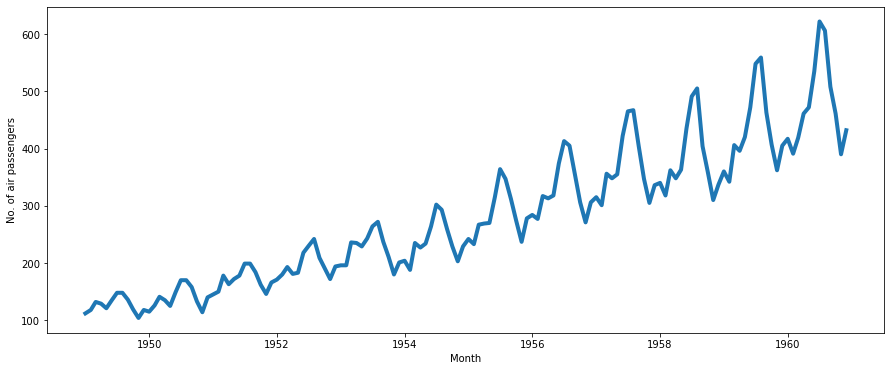

In [20]:
# Time Series plot
plt.figure(figsize = (15,6))
plt.plot(y,linewidth = 4)
plt.xlabel('Month')
plt.ylabel('No. of air passengers')
plt.show()

- From the above time series plot, we can observe positive trend over the years
- There is a presence of strong seasonality.
- It indicates that it is a multiplicative model as there is a gradual increase of variance over the time => y = T x S x I


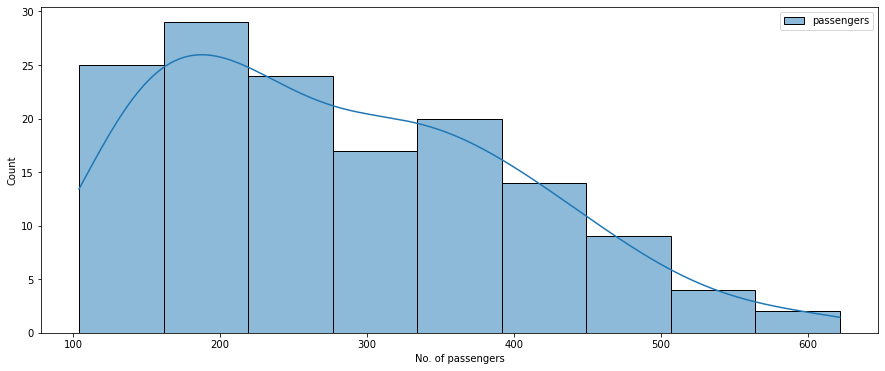

In [21]:
# Density Plot
plt.figure(figsize = (15,6))
sns.histplot(y, kde = True)
plt.xlabel('No. of passengers')
plt.ylabel('Count')
plt.show()

- From the above density plot, we observe that it is not perfectly normal distribution.
- It is right skewed.
- Transformations towards normal distribution might be useful prior to modelling.

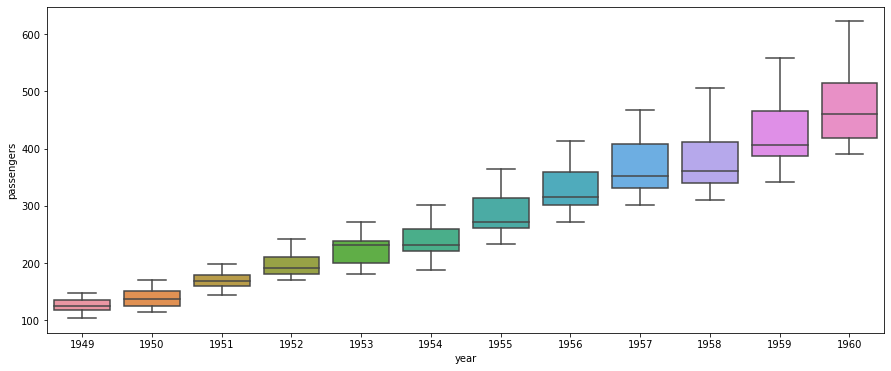

In [22]:
# Box-plot
plt.figure(figsize = (15,6))
sns.boxplot(x = y.index.year, y = y.passengers)
plt.show()

- From the above box-plot, we can see the median values of each box-plot increasing over time, indicating positive trend
- The size of boxes(50% of data) is increasing over time, indicating increase in spread or variance over the period.
- A model considering seasonality might work well

### Decomposition of Time Series

- Decomposition of time series helps us to visualize the trend, seasonal & residual components
- From above time series plot, we will assume the multiplicative model
- We will use statsmodels library to perform this task

<Figure size 1296x576 with 0 Axes>

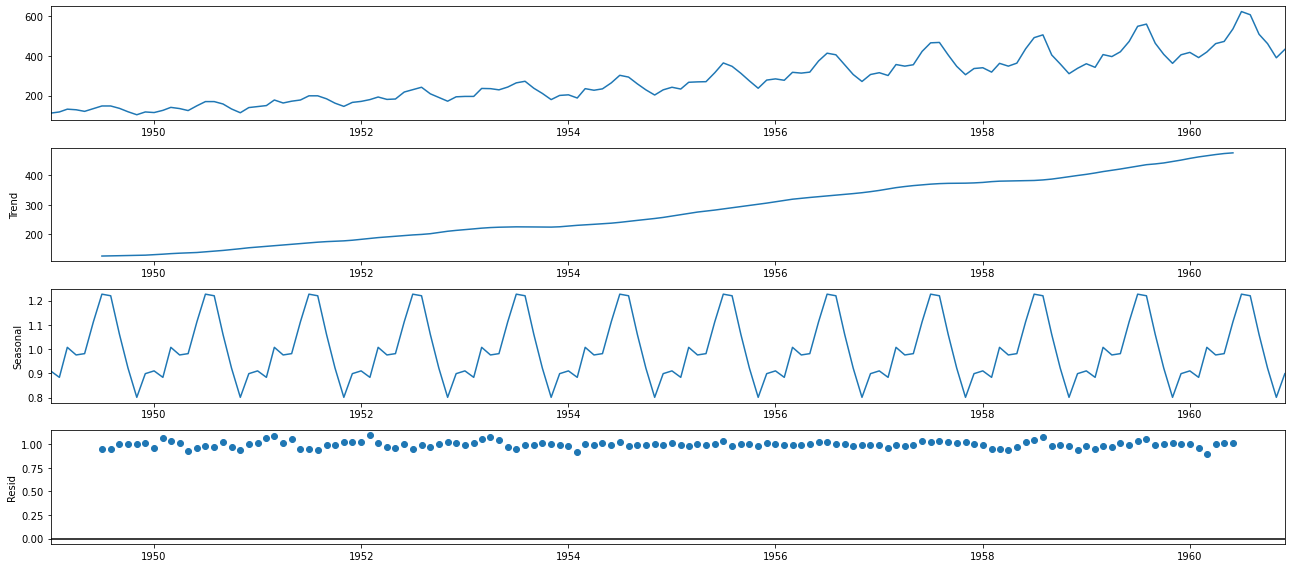

In [23]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
decomposition = sm.tsa.seasonal_decompose(y, model = 'multiplicative')
plt.figure(figsize = (18,8))
decomposition.plot()
plt.show()

### Stationarity of Time Series

- Time Series is said to be stationary when the time series data has __const. mean & variance__ over time. Also, the __correlation between the observations (yt,yt-1) is independent of time.__
- If the time series is not stationary, we will have to make it stationary as most of the models like ARIMA assume time series to be stationary.
- Also, stationary time series is easier to forecast as we know its statistical properties and they will tend to remain const over future.
- There are three ways to check the stationarity of time series, we will explore all three ways here :
    1. __Plotting ACF & PACF plots__ : If the time series is stationary, the ACF/PACF plots will show a __quick drop-off__ after certain lags.
    2. __Rolling Mean & Std. Deviation__ : Moving Avg. and Moving Std. Dev. is const. over time for a stationary time series.
    3. __Augmented Dickey Fuller test__ : It is a statistical test for checking stationarity of time series. 
      - Null Hypothesis(H0) : TS is non-stationary
      - Alternate Hypothesis(H1) : TS is stationary
      - If p-value < critical-value, we will reject null hyp. and accept alt. hyp.


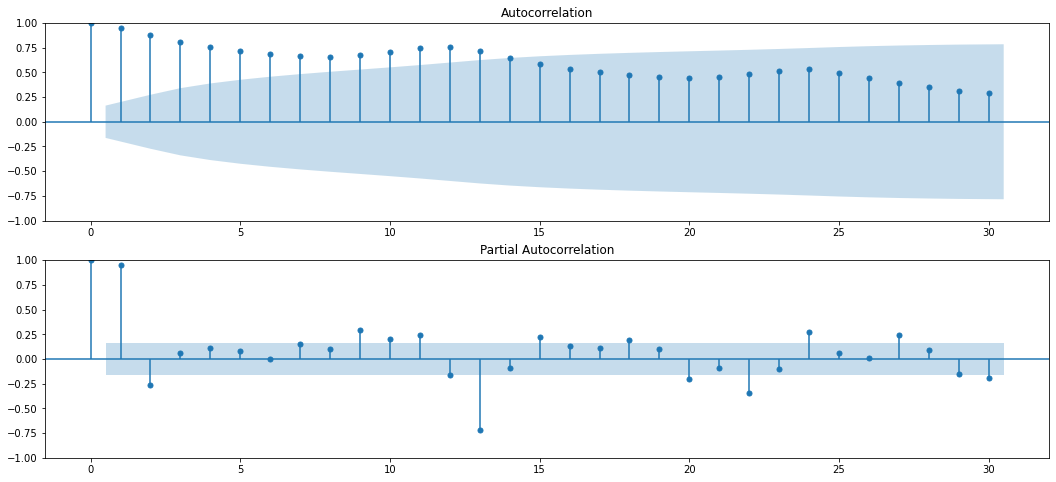

In [24]:
# ACF & PACF Plots
plt.figure()
plt.subplot(211)
plot_acf(y['passengers'], ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(y['passengers'], ax=plt.gca(), lags = 30)
plt.show()

- ACF is the plot of correlation between y(t) and y(t-k) for lag k
- PACF is the plot of correlation between y(t) and y(t-k) with intermediate lags removed.
- The shaded cone in both the plots is the confidence interval. By default, it is 95% CI or 5% significance level.
- ACF plot doesn't show quick drop off in correlation, hence we can infer that the TS is not stationary

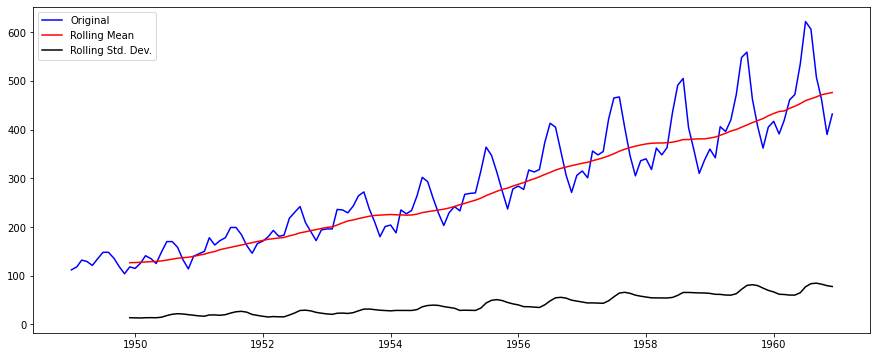

In [25]:
# Rolling Mean & Rolling Standard Deviation
rolmean = y.rolling(window = 12).mean()
rolstd = y.rolling(window = 12).std()

plt.figure(figsize = (15,6))
orig = plt.plot(y, color = 'blue', label ='Original')
mean  = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolstd, color = 'black', label = 'Rolling Std. Dev.')
plt.legend(loc = 'best')
plt.show()

- We can observe from the plot that rolling mean and rolling standard deviation are not constant with resepect to time.
- Hence, this confirms us that TS is not stationary in nature.

In [26]:
# Augmented Dicky-Fuller Test
print('-------------Results of Dicky Fuller Test -------------')
dftest = adfuller(y['passengers'], autolag = 'AIC')
dfoutput = pd.Series(data = dftest[0:4], index = ['Test Statistic : adf', 'p-value : MacKinnon\'s approximate p-value',
                                                 'No. of Lags used', 'No. of observations used'])
for key,value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
dfoutput['Maximized AIC:'] = dftest[5]
print(dfoutput)

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                           0.815369
p-value : MacKinnon's approximate p-value      0.991880
No. of Lags used                              13.000000
No. of observations used                     130.000000
Critical Value (1%)                           -3.481682
Critical Value (5%)                           -2.884042
Critical Value (10%)                          -2.578770
Maximized AIC:                               996.692931
dtype: float64


- Since p-value >  significance level (0.05), hence, we accept Null Hypothesis i.e, TS is non-stationary

In [27]:
# Creating general function to test stationarity of a time series

def test_stationarity(timeseries):
    # Rolling Mean & Rolling Standard Deviation
    rolmean = timeseries.rolling(window = 12).mean()
    rolstd = timeseries.rolling(window = 12).std()

    plt.figure(figsize = (15,6))
    orig = plt.plot(timeseries, color = 'blue', label ='Original')
    mean  = plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std. Dev.')
    plt.legend(loc = 'best')
    plt.show()
    
    # Augmented Dicky-Fuller Test
    print('-------------Results of Dicky Fuller Test -------------')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(data = dftest[0:4], index = ['Test Statistic : adf', 'p-value : MacKinnon\'s approximate p-value',
                                                     'No. of Lags used', 'No. of observations used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    dfoutput['Maximized AIC:'] = dftest[5]
    print(dfoutput)

### Making Time Series Stationary

- The trend and seasonality components contribute to the non-stationarity of the time series.
- There are three ways in which we can make time series stationary :-
    1. __Transformation__ : We can use various transformations like log, inverse, square root, box-cox, exponential etc.Common one is log transformation
    2. __Removing trend component from time series using smoothing technique__ : Smoothing technique can include moving avg, exponential weighted moving avg, LOESS etc.
    3. __Differencing__ : Difference between y(t) and y(t-k) for differencing of order k

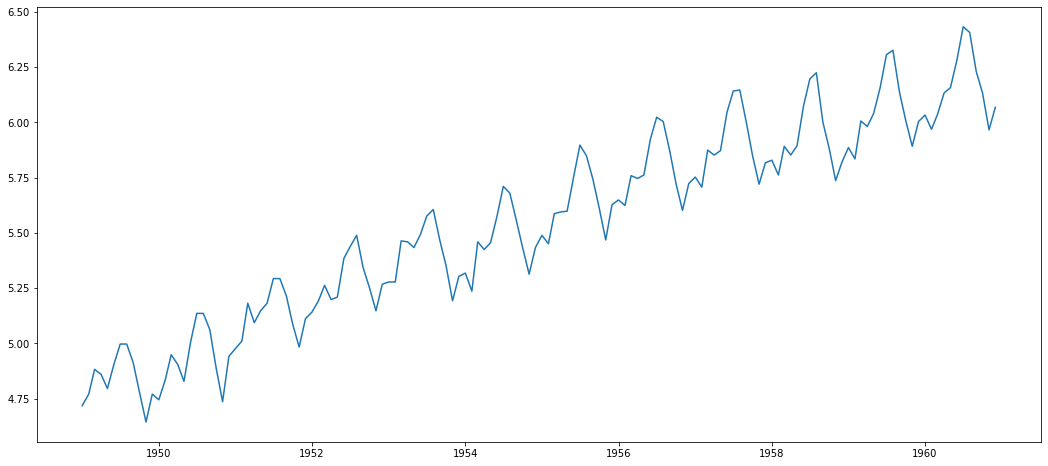

In [28]:
# Log Transformation
ts_log = np.log(y)
plt.plot(ts_log)

- After log transformation, still we can observe trend with prominent seasonality in the time series.
- Hence, intuitively, we can observe that TS is still non-stationary. Let's confirm this by doing stationarity tests.

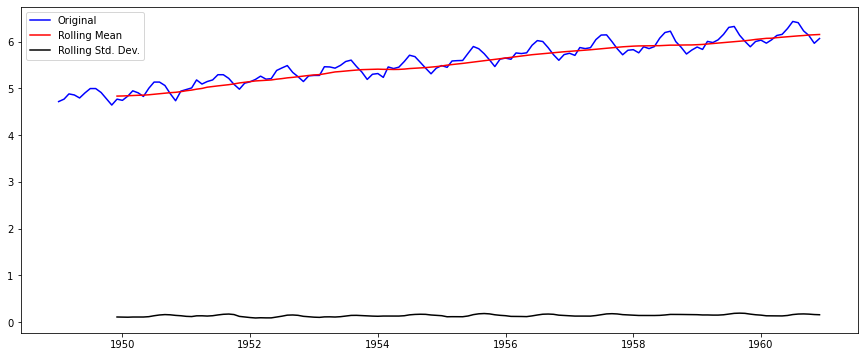

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -1.717017
p-value : MacKinnon's approximate p-value      0.422367
No. of Lags used                              13.000000
No. of observations used                     130.000000
Critical Value (1%)                           -3.481682
Critical Value (5%)                           -2.884042
Critical Value (10%)                          -2.578770
Maximized AIC:                              -445.399031
dtype: float64


In [29]:
# Stationarity test of log transformed TS
test_stationarity(ts_log)

- The above stationarity test confirms Rolling Mean & Rolling Std. Dev. aren't const. w.r.t time.
- Also, the p-value in ADF test is greater than significance level (0.05), which implies we to accept Null Hypothesis.
- Hence, log transformed TS is non-stationary in nature.

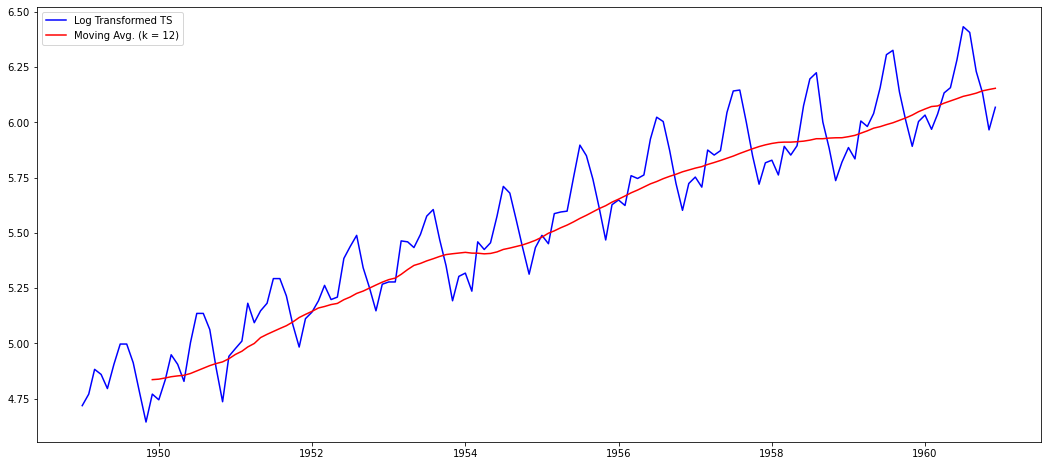

In [30]:
# Smoothing method : We will subtract Moving Avg. value from log transformed TS and then check its stationarity
mov_avg = ts_log.rolling(window = 12).mean()
plt.plot(ts_log, color = 'blue', label ='Log Transformed TS')
plt.plot(mov_avg, color = 'red', label = 'Moving Avg. (k = 12)')
plt.legend(loc = 'best')
plt.show()

In [31]:
ts_log_smu = ts_log - mov_avg

In [32]:
ts_log_smu

,passengers
year,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,0.282363
1960-09-01,0.098235
1960-10-01,-0.009230


In [33]:
# Removing NA values from differenced TS
ts_log_smu = ts_log_smu.dropna()
ts_log_smu

,passengers
year,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
...,...
1960-08-01,0.282363
1960-09-01,0.098235
1960-10-01,-0.009230


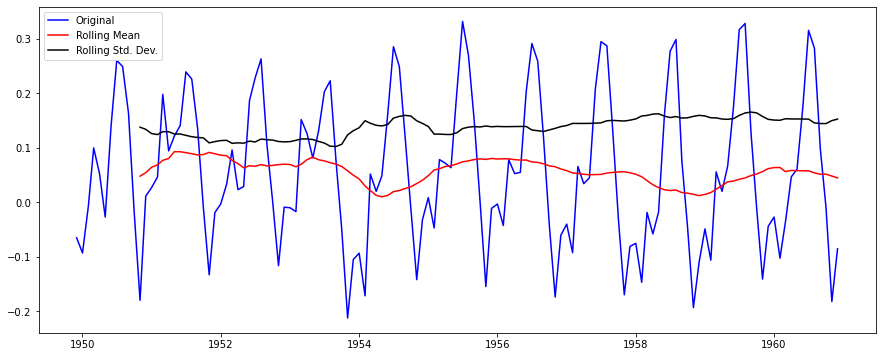

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -3.162908
p-value : MacKinnon's approximate p-value      0.022235
No. of Lags used                              13.000000
No. of observations used                     119.000000
Critical Value (1%)                           -3.486535
Critical Value (5%)                           -2.886151
Critical Value (10%)                          -2.579896
Maximized AIC:                              -436.632695
dtype: float64


In [34]:
# Checking stationarity of de-trended log transformed TS
test_stationarity(ts_log_smu)

- We can see that Rolling Mean & std. dev. are almost same over the time
- Also, ADF confirms that we can reject Null Hyp. (p-value < 0.05).
- Hence, log transformed de-trended TS is stationary in nature.
- We can use this data for our modelling. However, since we de-trended the TS, so forecasted values will also have values without trend component in them, and we will have to build separate model using regression technique to capture trend of forecasted values which turns out to be a complex process. Hence, we will go for other technique to make TS stationary which is pure differencing. 

In [35]:
# Differencing : on log transformed TS we will use differncing technique
ts_log_diff = ts_log - ts_log.shift(periods = 1) # first differencing

In [36]:
ts_log_diff

,passengers
year,
1949-01-01,NaN
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


In [37]:
# dropping NA values from differenced TS
ts_log_diff = ts_log_diff.dropna()

In [38]:
ts_log_diff

,passengers
year,
1949-02-01,0.052186
1949-03-01,0.112117
1949-04-01,-0.022990
1949-05-01,-0.064022
1949-06-01,0.109484
...,...
1960-08-01,-0.026060
1960-09-01,-0.176399
1960-10-01,-0.097083


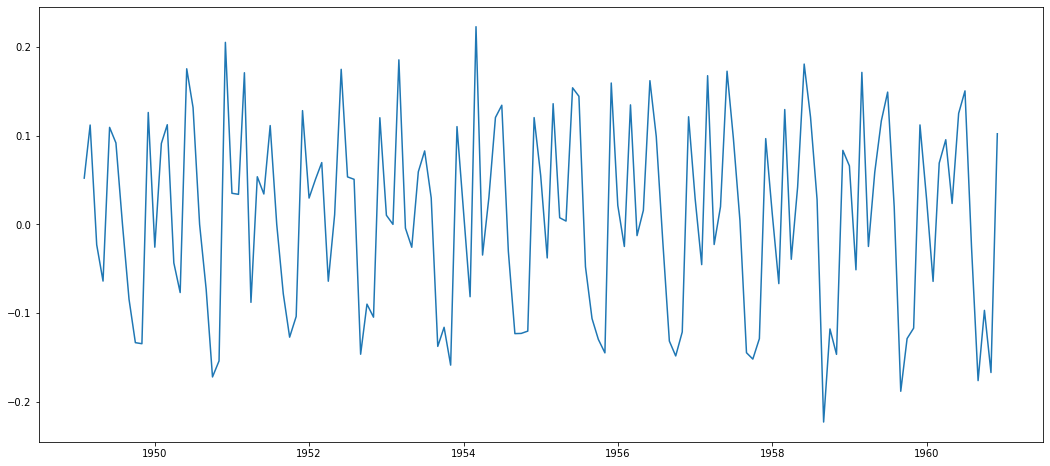

In [39]:
plt.plot(ts_log_diff)
plt.show()

- Intuitively, we can observe log transformed first differencing TS to be stationary.
- Let's confirm it using stationary test.

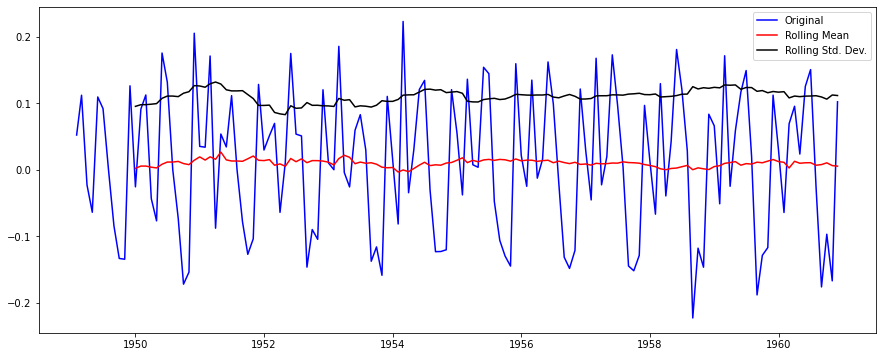

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -2.717131
p-value : MacKinnon's approximate p-value      0.071121
No. of Lags used                              14.000000
No. of observations used                     128.000000
Critical Value (1%)                           -3.482501
Critical Value (5%)                           -2.884398
Critical Value (10%)                          -2.578960
Maximized AIC:                              -440.358470
dtype: float64


In [40]:
# Checking stationarity on log transformed, first differencing TS
test_stationarity(ts_log_diff)

- We can observe that rolling mean & std. dev. are almost const. over time.
- However, we can observe that ADF test accepts Null Hyp. (p-value > 0.05 )
- Hence. TS is still non-stationary.
- Let's try differencing of order 2

In [41]:
# Differencing of order 2 on log transformed TS
ts_log_diff2 = ts_log - ts_log.shift(periods = 2)

In [42]:
ts_log_diff2

,passengers
year,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,0.164303
1949-04-01,0.089128
1949-05-01,-0.087011
...,...
1960-08-01,0.124613
1960-09-01,-0.202459
1960-10-01,-0.273482


In [43]:
# Dropping NA values
ts_log_diff2 = ts_log_diff2.dropna()

In [44]:
ts_log_diff2

,passengers
year,
1949-03-01,0.164303
1949-04-01,0.089128
1949-05-01,-0.087011
1949-06-01,0.045462
1949-07-01,0.201422
...,...
1960-08-01,0.124613
1960-09-01,-0.202459
1960-10-01,-0.273482


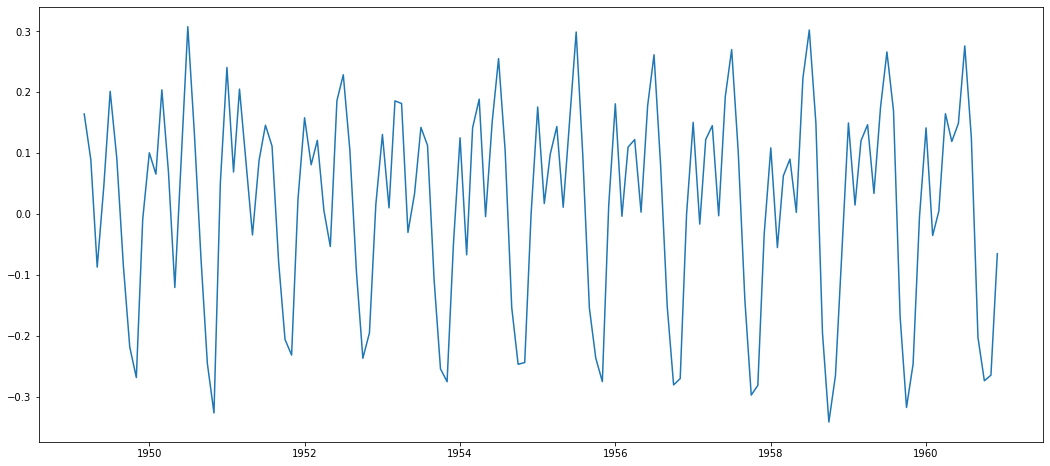

In [45]:
plt.plot(ts_log_diff2)
plt.show()

- Intuitively, TS plot confirms stationarity of TS.
- Lets confirm it using stationarity tests

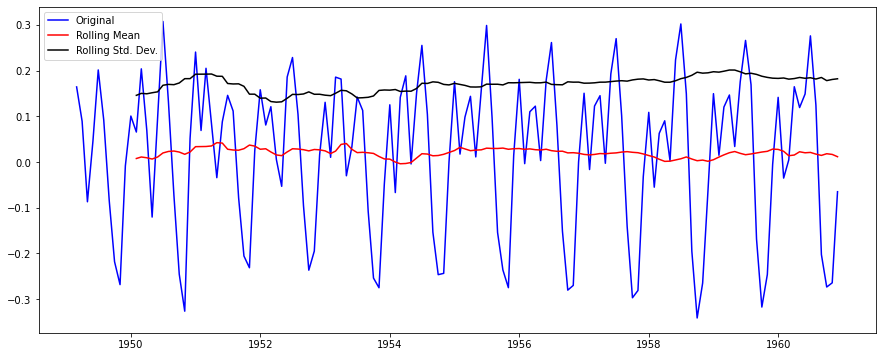

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -3.167907
p-value : MacKinnon's approximate p-value      0.021919
No. of Lags used                              11.000000
No. of observations used                     130.000000
Critical Value (1%)                           -3.481682
Critical Value (5%)                           -2.884042
Critical Value (10%)                          -2.578770
Maximized AIC:                              -431.937130
dtype: float64


In [46]:
# Checking stationarity of TS of diff. 2
test_stationarity(ts_log_diff2)

- Here, both the tests confirm that log transformed TS with differencing of order 2 is stationary as rolling mean & sd are 
almost const. over time.
- Also, p-value in ADF test is less than significance level (0.05), which infers that we can reject Null Hyp.
- We will use this data for model

### Model Building - ARIMA/SARIMA

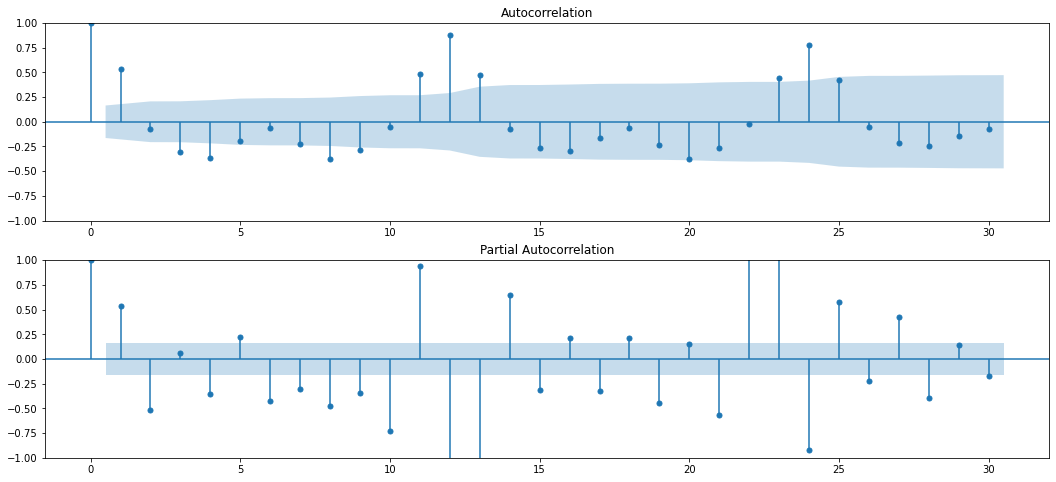

In [47]:
# Estimating p & q parameters from PACF & ACF plot resp.
plt.figure()
plt.subplot(211)
plot_acf(ts_log_diff2['passengers'], ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(ts_log_diff2['passengers'], ax=plt.gca(), lags = 30)
plt.show()

- ACF & PACF plots show that q = 2 & p = 3
- There are significant lags periodically, which signifies that seasonal differencing is also required. Hence, D = 1

In [48]:
# Seasonal Differencing
ts_log_seasonal_diff = ts_log - ts_log.shift(periods = 12)

In [49]:
ts_log_seasonal_diff

,passengers
year,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
...,...
1960-08-01,0.080731
1960-09-01,0.092754
1960-10-01,0.124585


In [50]:
# Dropping NA values
ts_log_seasonal_diff = ts_log_seasonal_diff.dropna()

In [51]:
ts_log_seasonal_diff

,passengers
year,
1950-01-01,0.026433
1950-02-01,0.065597
1950-03-01,0.065958
1950-04-01,0.045462
1950-05-01,0.032523
...,...
1960-08-01,0.080731
1960-09-01,0.092754
1960-10-01,0.124585


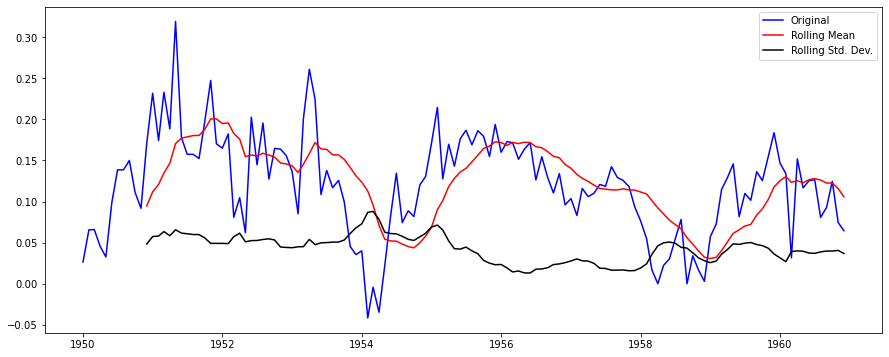

-------------Results of Dicky Fuller Test -------------
Test Statistic : adf                          -2.709577
p-value : MacKinnon's approximate p-value      0.072396
No. of Lags used                              12.000000
No. of observations used                     119.000000
Critical Value (1%)                           -3.486535
Critical Value (5%)                           -2.886151
Critical Value (10%)                          -2.579896
Maximized AIC:                              -424.760835
dtype: float64


In [52]:
# Checking stationarity of seasonally differenced data
test_stationarity(ts_log_seasonal_diff)

- The tests confirm that seasonally differenced TS is non-stationary

In [53]:
# Splitting TS data into train and test set for model training and testing
train_ts = ts_log.iloc[0:100,]
test_ts = ts_log.iloc[100: ,]

In [54]:
# Model 1 : ARIMA(3,2,2)
model1 = ARIMA(train_ts, order = (3,2,2))
results1 = model1.fit()

In [55]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  100
Model:                 ARIMA(3, 2, 2)   Log Likelihood                  85.355
Date:                Sat, 07 May 2022   AIC                           -158.711
Time:                        13:32:12   BIC                           -143.201
Sample:                    01-01-1949   HQIC                          -152.437
                         - 04-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6460      0.232     -2.788      0.005      -1.100      -0.192
ar.L2         -0.0466      0.153     -0.305      0.760      -0.346       0.253
ar.L3         -0.0600      0.145     -0.412      0.680      -0.345       0.225
ma.L1         -0.1336      2.707     -0.049      0.961      -5.439       5.172
ma.L2         -0.8644      2.296     -0.377      0.707      -5.364       3.635
sigma2         0.0098      0.026      0.371      0.711      -0.042       0.062
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 4.72
Prob(Q):                              0.86   Prob(JB):                         0.09
Heteroskedasticity (H):               0.90   Skew:                             0.19
Prob(H) (two-sided):                  0.77   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
predictions1 = results1.forecast(steps = len(test_ts))

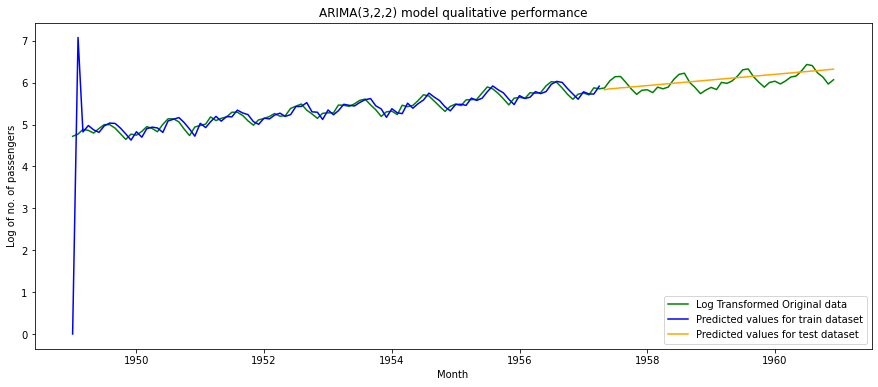

In [57]:
plt.figure(figsize = (15,6))
plt.plot(ts_log, color = 'green', label = 'Log Transformed Original data')
plt.plot(results1.fittedvalues, color = 'blue', label = 'Predicted values for train dataset')
plt.plot(predictions1, color = 'orange', label = 'Predicted values for test dataset')
plt.xlabel('Month')
plt.ylabel('Log of no. of passengers')
plt.title('ARIMA(3,2,2) model qualitative performance')
plt.legend(loc = 'best')
plt.show()

From the graph we observe that predictions on train dataset is very good but on 
test dataset is very poor. The model is overfitting.

In [60]:
# Evaluation metrics for model1
MSE_train_1 = mean_squared_error(train_ts, results1.fittedvalues)
print('Mean Squared Error (MSE) of model ARIMA(3,2,2) for trained data = ',MSE_train_1)
MAE_train_1 = mean_absolute_error(train_ts, results1.fittedvalues)
print('Mean Absolute Error (MAE) of model ARIMA(3,2,2) for trained data = ',MAE_train_1)
RMSE_train_1 = np.sqrt(MSE_train_1)
print('Root Mean Squared Error (RMSE) of model ARIMA(3,2,2) for trained data = ',RMSE_train_1)
MSE_test_1 = mean_squared_error(test_ts, predictions1)
print('Mean Squared Error (MSE) of model ARIMA(3,2,2) for test data = ',MSE_test_1)
MAE_test_1 = mean_absolute_error(test_ts, predictions1)
print('Mean Absolute Error (MAE) of model ARIMA(3,2,2) for test data = ',MAE_test_1)
RMSE_test_1 = np.sqrt(MSE_test_1)
print('Root Mean Squared Error (RMSE) of model ARIMA(3,2,2) for test data = ',RMSE_test_1)

Mean Squared Error (MSE) of model ARIMA(3,2,2) for trained data =  0.28586170911789455
Mean Absolute Error (MAE) of model ARIMA(3,2,2) for trained data =  0.15574157433330904
Root Mean Squared Error (RMSE) of model ARIMA(3,2,2) for trained data =  0.5346603680074805
Mean Squared Error (MSE) of model ARIMA(3,2,2) for test data =  0.029371429839410865
Mean Absolute Error (MAE) of model ARIMA(3,2,2) for test data =  0.15026715353404138
Root Mean Squared Error (RMSE) of model ARIMA(3,2,2) for test data =  0.17138094946466736


In [ ]:
# Model 2 : SARIMA => ARIMA(3,2,2)(0,1,0)[12] => seasonal differencing
model2 = ARIMA(train_ts, order = (3,2,2), seasonal_order=(0,1,0,12))
results2 = model2.fit()

In [ ]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  100
Model:             ARIMA(3, 2, 2)x(0, 1, [], 12)   Log Likelihood                 141.296
Date:                           Sat, 07 May 2022   AIC                           -270.592
Time:                                   13:49:35   BIC                           -255.866
Sample:                               01-01-1949   HQIC                          -264.666
                                    - 04-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1716      0.621     -0.276      0.782      -1.389       1.045
ar.L2         -0.0387      0.240     -0.161      0.872      -0.509       0.432
ar.L3         -0.2317      0.097     -2.391      0.017      -0.422      -0.042
ma.L1         -1.1656      0.602     -1.937      0.053      -2.345       0.014
ma.L2          0.1790      0.632      0.283      0.777      -1.059       1.417
sigma2         0.0021      0.000      5.904      0.000       0.001       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.13
Prob(Q):                              0.76   Prob(JB):                         0.94
Heteroskedasticity (H):               0.27   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
predictions2 = results2.forecast(steps = len(test_ts))

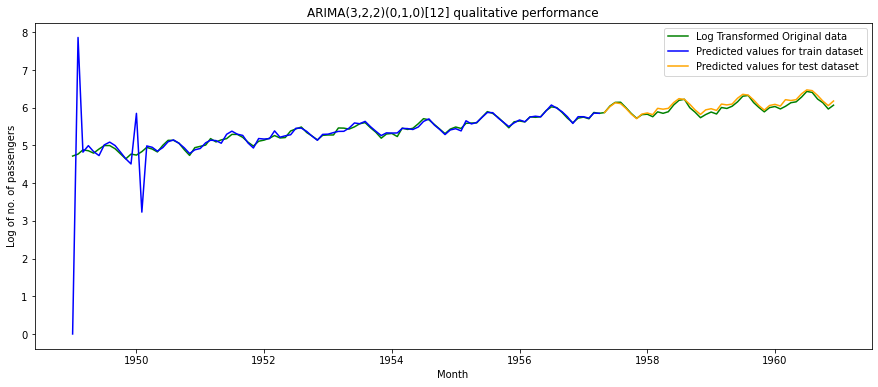

In [64]:
plt.figure(figsize = (15,6))
plt.plot(ts_log, color = 'green', label = 'Log Transformed Original data')
plt.plot(results2.fittedvalues, color = 'blue', label = 'Predicted values for train dataset')
plt.plot(predictions2, color = 'orange', label = 'Predicted values for test dataset')
plt.xlabel('Month')
plt.ylabel('Log of no. of passengers')
plt.title('ARIMA(3,2,2)(0,1,0)[12] qualitative performance')
plt.legend(loc = 'best')
plt.show()

This model is good at forecasting both training and test set . Hence, it appears to be a good model.

In [65]:
# Evaluation metrics for model2
MSE_train_2 = mean_squared_error(train_ts, results2.fittedvalues)
print('Mean Squared Error (MSE) of model ARIMA(3,2,2)(0,1,0)[12] for trained data = ',MSE_train_2)
MAE_train_2 = mean_absolute_error(train_ts, results2.fittedvalues)
print('Mean Absolute Error (MAE) of model ARIMA(3,2,2)(0,1,0)[12] for trained data = ',MAE_train_2)
RMSE_train_2 = np.sqrt(MSE_train_2)
print('Root Mean Squared Error (RMSE) of model ARIMA(3,2,2)(0,1,0)[12] for trained data = ',RMSE_train_2)
MSE_test_2 = mean_squared_error(test_ts, predictions2)
print('Mean Squared Error (MSE) of model ARIMA(3,2,2)(0,1,0)[12] for test data = ',MSE_test_2)
MAE_test_2 = mean_absolute_error(test_ts, predictions2)
print('Mean Absolute Error (MAE) of model ARIMA(3,2,2)(0,1,0)[12] for test data = ',MAE_test_2)
RMSE_test_2 = np.sqrt(MSE_test_2)
print('Root Mean Squared Error (RMSE) of model ARIMA(3,2,2)(0,1,0)[12] for test data = ',RMSE_test_2)

Mean Squared Error (MSE) of model ARIMA(3,2,2)(0,1,0)[12] for trained data =  0.35958639169931933
Mean Absolute Error (MAE) of model ARIMA(3,2,2)(0,1,0)[12] for trained data =  0.14586233660324927
Root Mean Squared Error (RMSE) of model ARIMA(3,2,2)(0,1,0)[12] for trained data =  0.599655227359288
Mean Squared Error (MSE) of model ARIMA(3,2,2)(0,1,0)[12] for test data =  0.005181943438536841
Mean Absolute Error (MAE) of model ARIMA(3,2,2)(0,1,0)[12] for test data =  0.06196659125964503
Root Mean Squared Error (RMSE) of model ARIMA(3,2,2)(0,1,0)[12] for test data =  0.07198571690645889


In [66]:
# Model 3 : Auto-ARIMA of pyramid module
model3 = auto_arima(y = train_ts)
results3 = model3.fit(y = train_ts)

In [67]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(4, 1, 2)   Log Likelihood                 102.530
Date:                Sat, 07 May 2022   AIC                           -189.060
Time:                        13:50:07   BIC                           -168.300
Sample:                             0   HQIC                          -180.661
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0113      0.002      4.930      0.000       0.007       0.016
ar.L1          0.0689      0.172      0.401      0.689      -0.268       0.406
ar.L2          0.3570      0.166      2.148      0.032       0.031       0.683
ar.L3         -0.2427      0.125     -1.945      0.052      -0.487       0.002
ar.L4         -0.2021      0.115     -1.759      0.079      -0.427       0.023
ma.L1         -0.1161      0.142     -0.819      0.413      -0.394       0.162
ma.L2         -0.8202      0.150     -5.467      0.000      -1.114      -0.526
sigma2         0.0071      0.002      4.241      0.000       0.004       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 4.60
Prob(Q):                              0.68   Prob(JB):                         0.10
Heteroskedasticity (H):               0.85   Skew:                             0.18
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
predictions3 = results3.predict(n_periods = len(test_ts))

In [69]:
predictions3 = pd.DataFrame(predictions3 , index = test_ts.index, columns = ['passengers'])

In [70]:
train_predict = results3.predict_in_sample(start = 1, end = 100)

In [71]:
train_predict = pd.DataFrame(train_predict , index = train_ts.index, columns = ['passengers'])

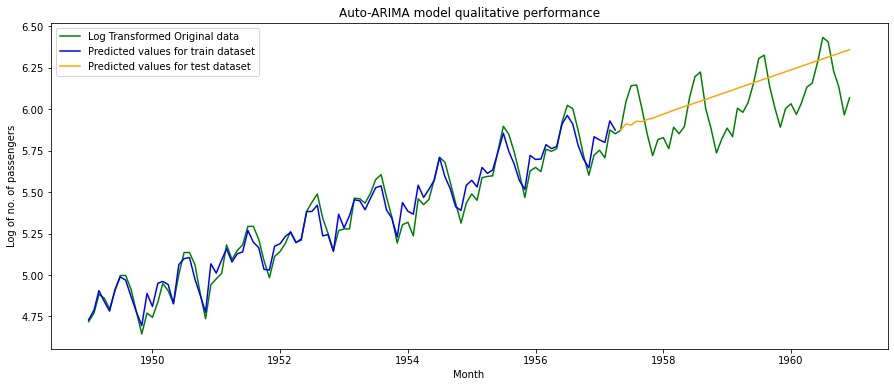

In [72]:
plt.figure(figsize = (15,6))
plt.plot(ts_log, color = 'green', label = 'Log Transformed Original data')
plt.plot(train_predict, color = 'blue', label = 'Predicted values for train dataset')
plt.plot(predictions3, color = 'orange', label = 'Predicted values for test dataset')
plt.xlabel('Month')
plt.ylabel('Log of no. of passengers')
plt.title('Auto-ARIMA model qualitative performance')
plt.legend(loc = 'best')
plt.show()

Surprisingly the auto-arima model is performing poorly on test dataset and good on train dataset.This model is also overfitting

In [73]:
# Evaluation metrics for model3
MSE_train_3 = mean_squared_error(train_ts, train_predict)
print('Mean Squared Error (MSE) of model Auto-ARIMA for trained data = ',MSE_train_3)
MAE_train_3 = mean_absolute_error(train_ts, train_predict)
print('Mean Absolute Error (MAE) of model Auto-ARIMA for trained data = ',MAE_train_3)
RMSE_train_3 = np.sqrt(MSE_train_3)
print('Root Mean Squared Error (RMSE) of model Auto-ARIMA for trained data = ',RMSE_train_3)
MSE_test_3 = mean_squared_error(test_ts, predictions3)
print('Mean Squared Error (MSE) of model Auto-ARIMA] for test data = ',MSE_test_3)
MAE_test_3= mean_absolute_error(test_ts, predictions3)
print('Mean Absolute Error (MAE) of model Auto-ARIMA for test data = ',MAE_test_3)
RMSE_test_3 = np.sqrt(MSE_test_3)
print('Root Mean Squared Error (RMSE) of model Auto-ARIMA for test data = ',RMSE_test_3)

Mean Squared Error (MSE) of model Auto-ARIMA for trained data =  0.0034716785276866936
Mean Absolute Error (MAE) of model Auto-ARIMA for trained data =  0.04765217179254182
Root Mean Squared Error (RMSE) of model Auto-ARIMA for trained data =  0.05892095151715299
Mean Squared Error (MSE) of model Auto-ARIMA] for test data =  0.03490072597604508
Mean Absolute Error (MAE) of model Auto-ARIMA for test data =  0.1646179917540459
Root Mean Squared Error (RMSE) of model Auto-ARIMA for test data =  0.1868173599429268


### Comapring the models

We use AIC,BIC and log-likelihood metrics for comparing model performances. The model with minimum AIC & BIC or maximum log-likelihood is considered the best model.

In [74]:
Model_Comparison = pd.DataFrame({'Model' : ['ARIMA(3,2,2)', 'ARIMA(3,2,2)(0,1,0)[12]','Auto-ARIMA : SARIMAX(4,1,2)'],
                                 'AIC' : [results1.aic, results2.aic, results3.aic()],
                                 'BIC' : [results1.bic, results2.bic, results3.bic()],
                                 'Log-Likelihood' : [results1.llf, results2.llf, (results3.aic() - 2*len(results3.params()))/(-2)]})

Model_Comparison

,Model,AIC,BIC,Log-Likelihood
0,"ARIMA(3,2,2)",-158.710795,-143.200990,85.355397
1,"ARIMA(3,2,2)(0,1,0)[12]",-270.592300,-255.866216,141.296150
2,"Auto-ARIMA : SARIMAX(4,1,2)",-189.060497,-168.299539,102.530249


By comparing the metrics, __ARIMA(3,2,2)(0,1,0)[12]__ is having the min. AIC & BIC and max. Log-likelihood. Hence, it is the best model.

###### In the above model predictions, the predictions are log values, hence to get actual predicted values we need to perform exponential transform over the log transform to get original forecasted values

In [75]:
# Getting original forecasted values for the best model : model2 => ARIMA(3,2,2)(0,1,0)[12]
actual_predictions2 = np.exp(predictions2)
actual_predictions2

1957-05-01    355.592599
1957-06-01    414.958933
1957-07-01    460.001106
1957-08-01    450.516918
1957-09-01    395.804620
1957-10-01    340.891981
1957-11-01    302.131493
1957-12-01    341.078859
1958-01-01    351.326098
1958-02-01    335.759281
1958-03-01    397.276440
1958-04-01    388.425184
1958-05-01    397.031952
1958-06-01    463.434437
1958-07-01    513.899625
1958-08-01    503.442562
1958-09-01    442.434404
1958-10-01    381.159734
1958-11-01    337.919419
1958-12-01    381.589193
1959-01-01    393.167592
1959-02-01    375.854752
1959-03-01    444.846678
1959-04-01    435.060756
1959-05-01    444.829258
1959-06-01    519.375326
1959-07-01    576.098290
1959-08-01    564.538270
1959-09-01    496.269504
1959-10-01    427.662244
1959-11-01    379.255833
1959-12-01    428.391053
1960-01-01    441.516823
1960-02-01    422.196666
1960-03-01    499.839210
1960-04-01    488.984499
1960-05-01    500.107929
1960-06-01    584.086170
1960-07-01    648.063273
1960-08-01    635.242322


In [76]:
# original predicted train values of model2
actual_train_predict2 = np.exp(results2.fittedvalues)
actual_train_predict2

year
1949-01-01       1.000000
1949-02-01    2602.336000
1949-03-01     124.321430
1949-04-01     147.661016
1949-05-01     126.068182
                 ...     
1956-12-01     318.024940
1957-01-01     318.092036
1957-02-01     306.273682
1957-03-01     349.779447
1957-04-01     348.236739
Length: 100, dtype: float64

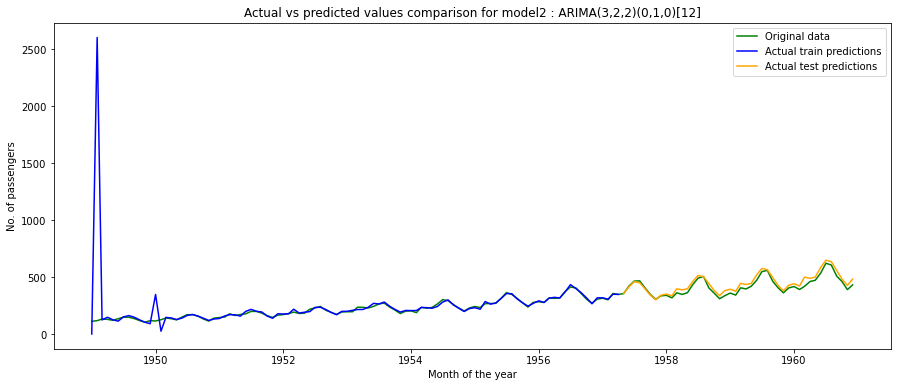

In [77]:
# Plotting actual vs forecasted values
plt.figure(figsize = (15,6))
plt.plot(y, color = 'green', label = 'Original data')
plt.plot(actual_train_predict2, color = 'blue', label = 'Actual train predictions')
plt.plot(actual_predictions2, color = 'orange', label = 'Actual test predictions')
plt.ylabel('No. of passengers')
plt.xlabel('Month of the year')
plt.title('Actual vs predicted values comparison for model2 : ARIMA(3,2,2)(0,1,0)[12]')
plt.legend(loc = 'best')
plt.show()

### Model Validation

We validate the Time Series model by analyzing the residuals :
1. Residuals should be white noise, i.e, they should be stationary in nature (const. mean & variance over time). We will use ACF & PACF plots for residuals to test this. Quick drop off after certain lags in ACF & PACF plots will confirm it.
2. Residuals should follow normal distribution. We will use histogram and q-q plot to confirm this.
3. There is a statistical test Ljung-Box test which checks whether TS model is a good fit or not using Q-statistic. 
   - H0: Model is a good fit
   - H1: Model is not a good fit
   - Reject H0 if, Q > chi-square(1-alpha,h) (h = m-p-q, p&q are arima model para. and h is max. lag considered) or p-value < alpha

In [78]:
# Validating our best model chosen => model2 => ARIMA(3,2,2)(0,1,0)
residual = results2.resid

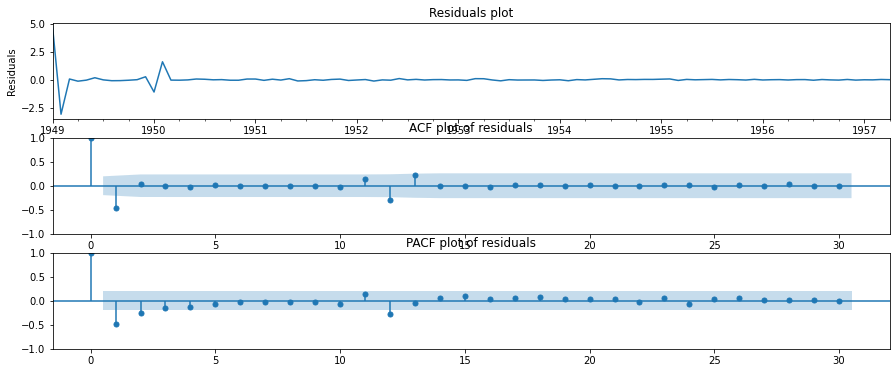

In [79]:
# 1. Checking white noise of residuals
plt.figure(figsize = (15,6))
plt.subplot(3,1,1)
residual.plot(kind = 'line', xlabel = 'Month', ylabel = 'Residuals', title = 'Residuals plot')
plt.subplot(3,1,2)
plot_acf(residual, ax=plt.gca(), lags = 30, title = 'ACF plot of residuals')
plt.subplot(3,1,3)
plot_pacf(residual, ax=plt.gca(), lags = 30, title = 'PACF plot of residuals')
plt.show()

From ACF and PACF plots, we can observe that almost all lags are 0, it indicates white noise

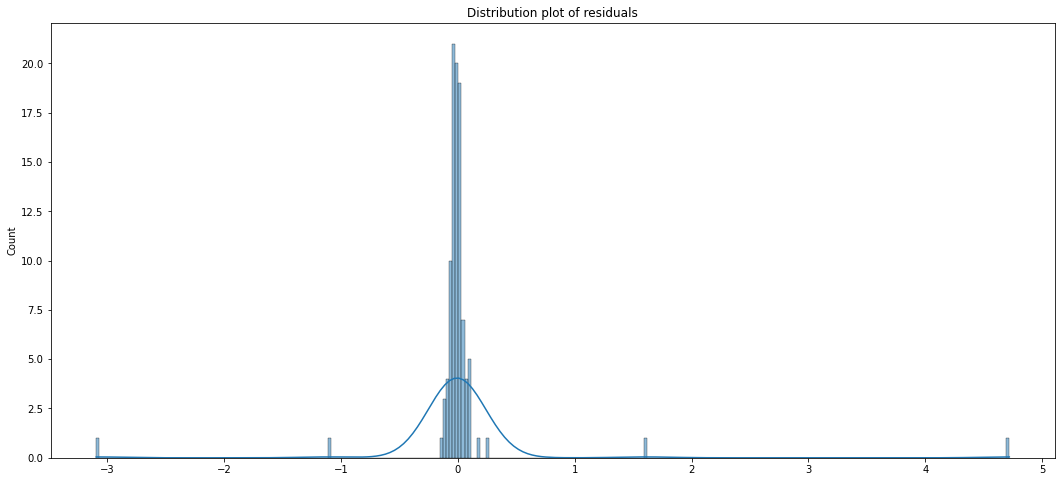

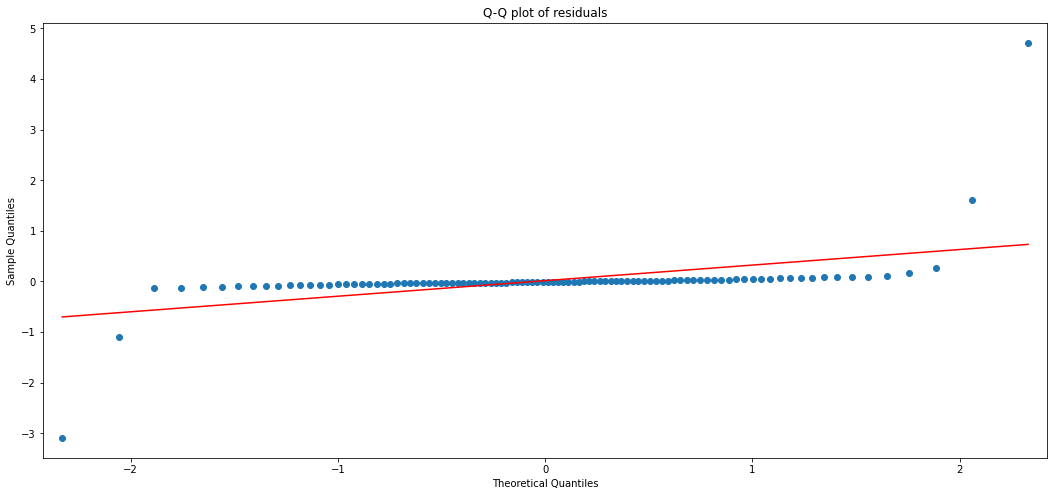

In [80]:
# 2. Checking normality of residuals using distribution plot and q-q plot
plt.figure()
sns.histplot(residual, kde = True)
plt.title('Distribution plot of residuals')
sm.qqplot(residual, line = 'r')
plt.title('Q-Q plot of residuals')
plt.show()

From above plots, we can observe that residuals follow normal distribution

In [81]:
# 3. Ljung-Box residual test on our best model => model2 => ARIMA(3,2,2)(0,1,0)[12]
# For determining max. lags for L-B test, we will use folling formulae :
# h = min(10,n/5) --- for non-seasonal TS
# h = min(2m,n/5) --- for seasonal TS
# n = length of time series
# m = seasonal period

# In our case, we have seasonal ts 
n = len(train_ts)
m = 12
h = min(2*m,n/5)

sm.stats.acorr_ljungbox(x = residual,lags = [h], return_df = True)

,lb_stat,lb_pvalue
20,40.306697,0.004568


Since, p-value < 0.05, we reject H0 . Hence, current model is not a good fit.

In [82]:
# Lets test for auto_arima model : SARIMAX(4,1,2)
residual_auto_arima = results3.resid()
residual_aa_df = pd.DataFrame({'residuals' : residual_auto_arima}, index = train_ts.index)
residual_aa_df

,residuals
year,
1949-01-01,4.707412
1949-02-01,0.041099
1949-03-01,0.094102
1949-04-01,-0.045791
1949-05-01,-0.043646
...,...
1956-12-01,0.076927
1957-01-01,-0.081404
1957-02-01,-0.107966


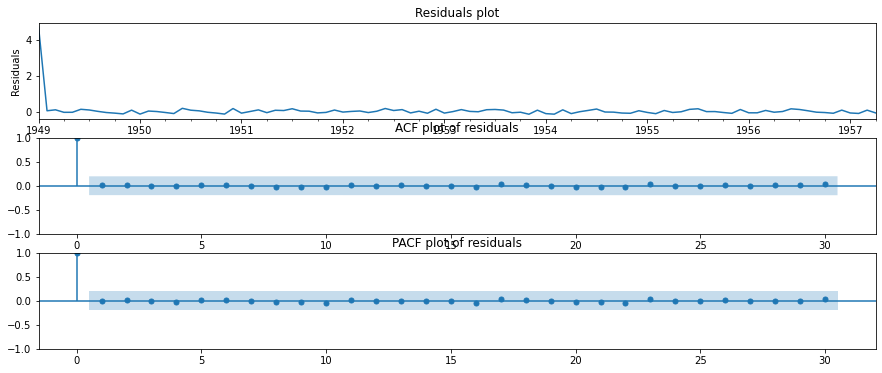

In [83]:
# 1. Checking white noise of residuals
plt.figure(figsize = (15,6))
plt.subplot(3,1,1)
residual_aa_df['residuals'].plot(kind = 'line', xlabel = 'Month', ylabel = 'Residuals', title = 'Residuals plot')
plt.subplot(3,1,2)
plot_acf(residual_aa_df['residuals'], ax=plt.gca(), lags = 30, title = 'ACF plot of residuals')
plt.subplot(3,1,3)
plot_pacf(residual_aa_df['residuals'], ax=plt.gca(), lags = 30, title = 'PACF plot of residuals')
plt.show()

From ACF and PACF plots, we can observe that almost all lags are 0, it indicates white noise

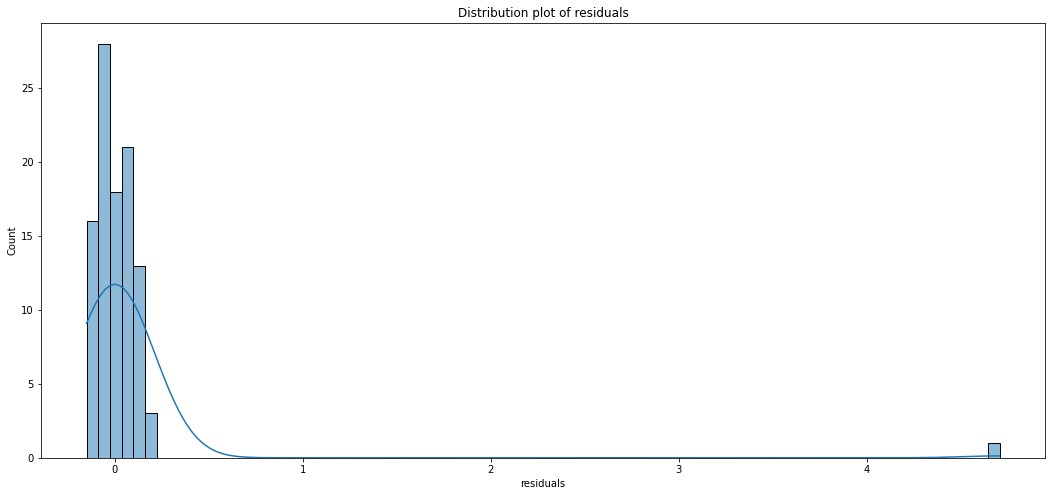

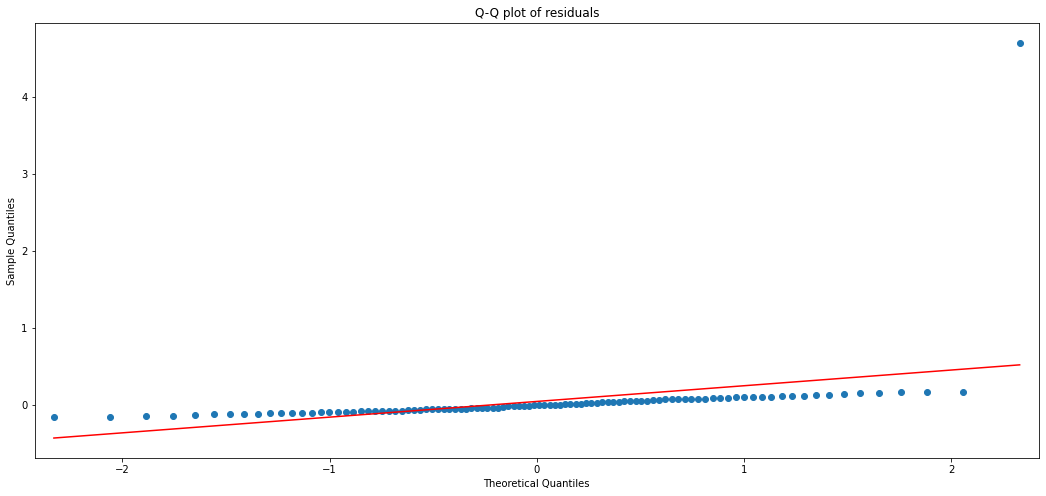

In [84]:
# 2. Checking normality of residuals using distribution plot and q-q plot
plt.figure()
sns.histplot(residual_aa_df['residuals'], kde = True)
plt.title('Distribution plot of residuals')
sm.qqplot(residual_aa_df['residuals'], line = 'r')
plt.title('Q-Q plot of residuals')
plt.show()

Here, plots doesn't indicate normality of residuals

In [85]:
# 3. Ljung-Box residual test on our auto arima model
# For determining max. lags for L-B test, we will use following formulae :
# h = min(10,n/5) --- for non-seasonal TS
# h = min(2m,n/5) --- for seasonal TS
# n = length of time series
# m = seasonal period

# In our case, we have seasonal ts 
n = len(train_ts)
m = 12
h = min(2*m,n/5)

sm.stats.acorr_ljungbox(x = residual_aa_df['residuals'],lags = [h], return_df = True)

,lb_stat,lb_pvalue
20,0.774329,1.0


Since, p-value is more than 0.05, we accept H0 hypothesis, i.e, model is a good fit

### Hence, after evaluating all the steps, we will go for auto-arima model : SARIMAX(4,1,2)

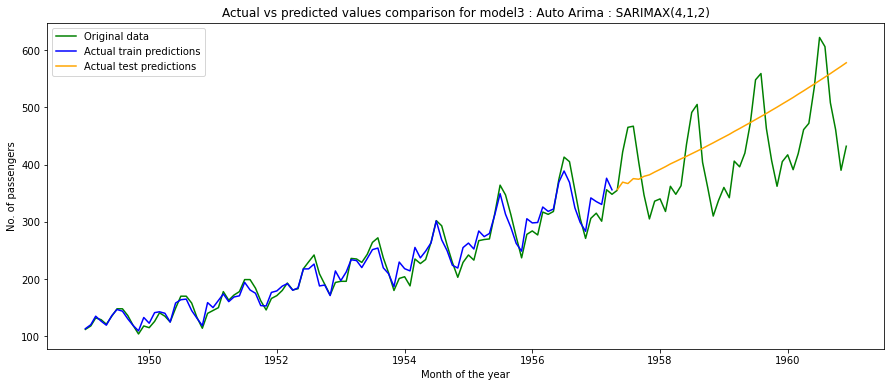

In [89]:
# Actual vs forecasted values of auto-arima model on original TS
actual_train_predict3 = np.exp(train_predict) # log to original transform of train predictions by auto-arima
actual_test_predict3 = np.exp(predictions3) # log to original transform of test predictions by auto-arima

# Plotting actual vs forecasted values
plt.figure(figsize = (15,6))
plt.plot(y, color = 'green', label = 'Original data')
plt.plot(actual_train_predict3, color = 'blue', label = 'Actual train predictions')
plt.plot(actual_test_predict3, color = 'orange', label = 'Actual test predictions')
plt.ylabel('No. of passengers')
plt.xlabel('Month of the year')
plt.title('Actual vs predicted values comparison for model3 : Auto Arima : SARIMAX(4,1,2)')
plt.legend(loc = 'best')
plt.show()